In [123]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [124]:
def imread(path):
    return np.array(Image.open(path)).astype(float) / 255

# 1. Noising Processes

In [125]:
def additive_white_noise(im, std):
    eps = std * np.random.randn(*im.shape)
    return np.clip(im + eps, 0, 1)
    

def salt_and_pepper_noise(im, p):
    _im = im.copy()
    h, w = im.shape
    for i in range(h):
        for j in range(w):
            prob = np.random.rand()
            if prob > p:
                pass
            else:
                new_val = np.random.choice([0, 1])
                _im[i, j] = new_val
    return _im

In [126]:
im = imread('../../data/set68/test001.png')

In [127]:
im_g = additive_white_noise(im, 30 / 255)

In [128]:
im_s = salt_and_pepper_noise(im, p=0.1)

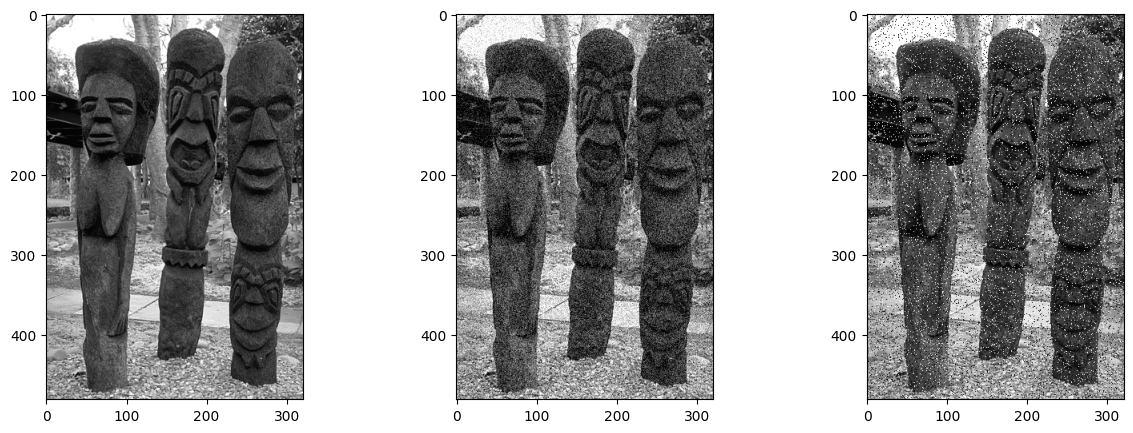

In [129]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(im, cmap='gray')
axes[1].imshow(im_g, cmap='gray')
axes[2].imshow(im_s, cmap='gray')

# 2. Metrics

In [130]:
def mse(f_true, f):
    return np.mean((f - f_true) ** 2)


def psnr(f_true, f):
    return 10 * np.log10(1 / (mse(f_true, f) + 1e-11))

In [140]:
np.std(im - im_g) ** 2

0.01246967242752368

In [132]:
print(mse(im, im_g), mse(im, im_s))

0.012471659944388185 0.03219399021358728


In [107]:
print(psnr(im, im_g), psnr(im, im_s))

6.846052498734549 14.88590272681188


In [146]:
sigma_range = np.logspace(-2, 0, 40)
yp, ym = [], []

for sigma in sigma_range:
    im_g = additive_white_noise(im, sigma)
    yp.append(psnr(im, im_g))
    ym.append(mse(im, im_g))

Text(0, 0.5, 'PSNR')

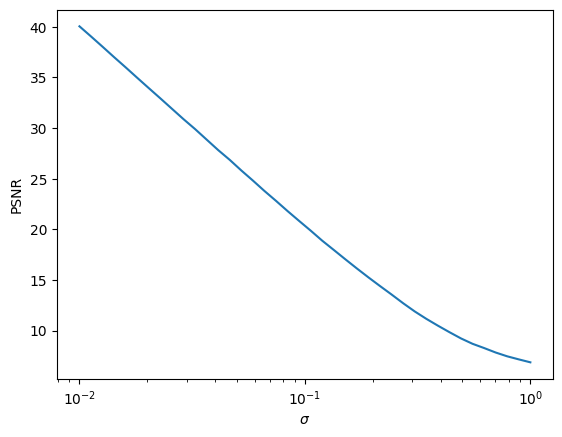

In [147]:
plt.plot(sigma_range, yp)
plt.xscale('log')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'PSNR')

Text(0, 0.5, 'MSE')

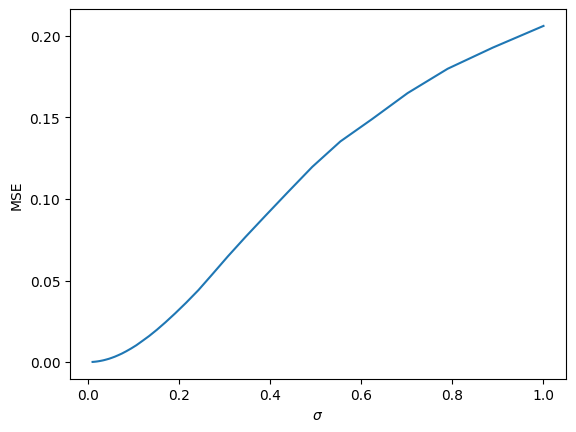

In [151]:
plt.plot(sigma_range, ym)
plt.xlabel(r'$\sigma$')
plt.ylabel(r'MSE')

In [159]:
p_range = np.linspace(0.1, 1, 40)
yp, ym = [], []

for p in p_range:
    im_s = salt_and_pepper_noise(im, p)
    yp.append(psnr(im, im_s))
    ym.append(mse(im, im_s))

Text(0, 0.5, 'p')

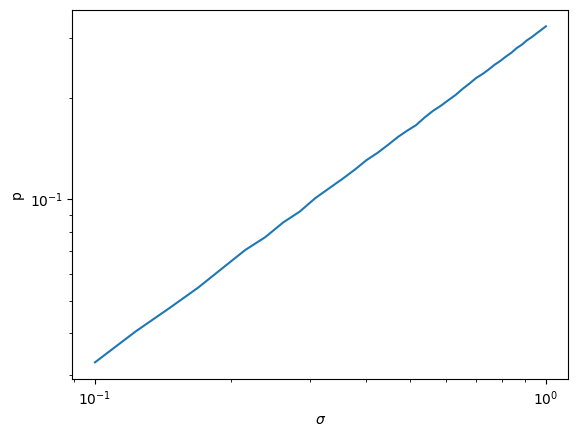

In [164]:
plt.plot(p_range, ym)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'p')

Text(0, 0.5, 'p')

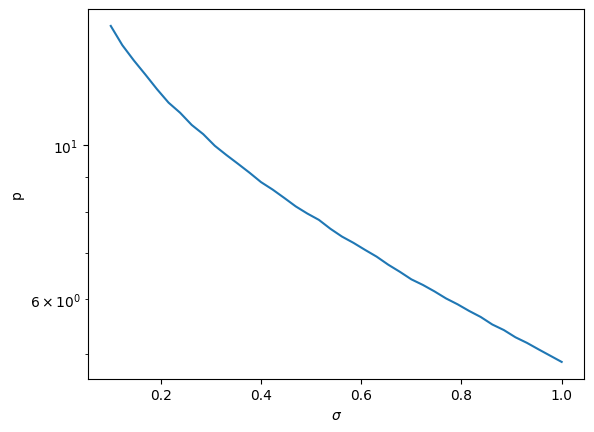

In [166]:
plt.plot(p_range, yp)
plt.yscale('log')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'p')

## 3. Linear Filtering

In [192]:
def kernel(X, Y, sigma):
    kernel = np.exp(- (X ** 2 + Y ** 2) / (2 * (sigma ** 2)))
    return kernel / kernel.sum()

In [193]:
def fourier_transform(im):
    return np.fft.fftshift(np.fft.fft2(im))

In [235]:
im = imread('../../data/set68/test001.png')
im_g = additive_white_noise(im, 30 / 255)
im_s = salt_and_pepper_noise(im, 0.1)

In [215]:
h, w = im.shape

In [267]:
x = np.concatenate([np.arange(- h // 2, 0), np.arange(0, h // 2)])
y = np.concatenate([np.arange(- w // 2, 0), np.arange(0, w // 2)])

X, Y = np.meshgrid(x, y)
g = G(X, Y, 1).T

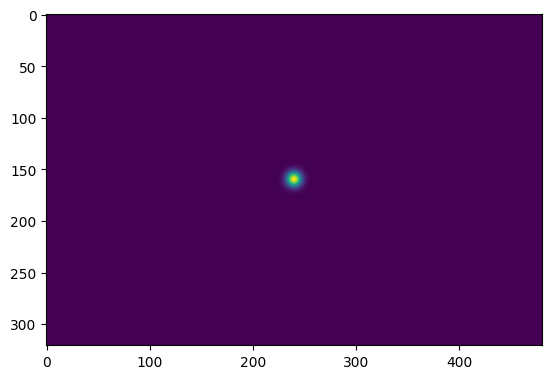

In [268]:
plt.imshow(np.fft.fftshift(g_fft))

In [273]:
im_denoised = np.fft.ifftshift(np.fft.ifft2(np.fft.fft2(im_g) * np.fft.fft2(g))).real

In [274]:
p0 = psnr(im, im_g)
m0 = mse(im, im_g)

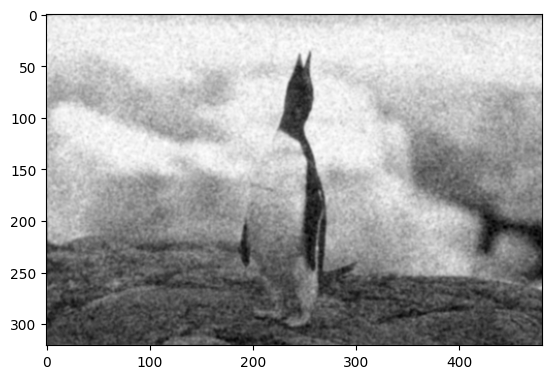

In [275]:
plt.imshow(im_denoised, cmap='gray')

## 3.3. Choosing $\sigma$

In [227]:
sigma_range = np.logspace(-1, 1, 40)
yp, ym = [], []
for sigma in sigma_range:
    g = G(X, Y, sigma).T
    im_denoised = np.fft.ifft2(np.fft.fft2(im_g) * np.fft.fft2(g)).real
    
    yp.append(psnr(im_denoised, im))
    ym.append(mse(im_denoised, im))

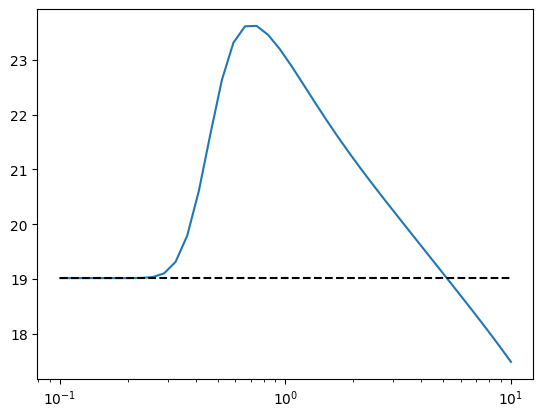

In [233]:
plt.plot(sigma_range, yp)
plt.plot(sigma_range, [p0] * len(sigma_range), 'k--')
plt.xscale('log')

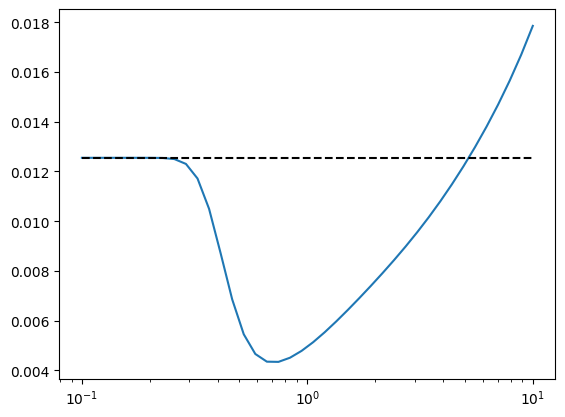

In [234]:
plt.plot(sigma_range, ym)
plt.plot(sigma_range, [m0] * len(sigma_range), 'k--')
plt.xscale('log')

In [237]:
sigma_range = np.logspace(-1, 1, 40)
yp, ym = [], []
for sigma in sigma_range:
    g = G(X, Y, sigma).T
    im_denoised = np.fft.ifft2(np.fft.fft2(im_s) * np.fft.fft2(g)).real
    
    yp.append(psnr(im_denoised, im))
    ym.append(mse(im_denoised, im))

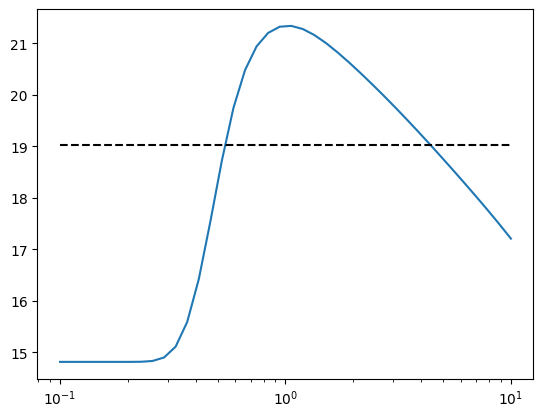

In [238]:
plt.plot(sigma_range, yp)
plt.plot(sigma_range, [p0] * len(sigma_range), 'k--')
plt.xscale('log')

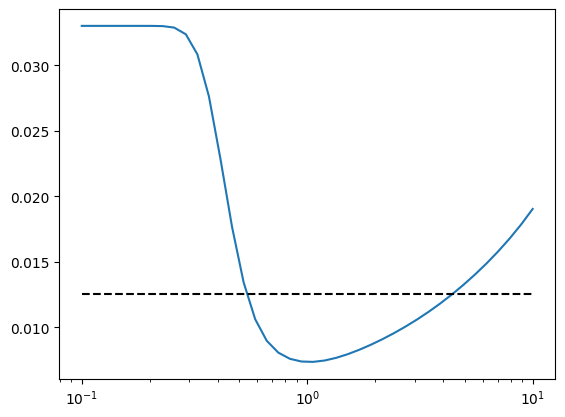

In [239]:
plt.plot(sigma_range, ym)
plt.plot(sigma_range, [m0] * len(sigma_range), 'k--')
plt.xscale('log')

# 4. Exploring Linear Filtering Visualy

In [242]:
import os
from tqdm.auto import tqdm

In [241]:
base_path = '../../data/set68'
filenames = os.listdir(base_path)
sigma_range = np.logspace(-1, 1, 40)

In [258]:
y_psnr = []
y_mse = []

for fname in tqdm(filenames):
    if '.md' in fname:
        continue
    fpath = os.path.join(base_path, fname)
    im = imread(fpath)
    im_g = additive_white_noise(im, 30 / 255)

    h, w = im.shape
    x = np.concatenate([np.arange(0, h // 2), np.arange(- h // 2, 0)])
    y = np.concatenate([np.arange(0, w // 2), np.arange(- w // 2, 0)])
    X, Y = np.meshgrid(x, y)

    _psnr = []
    _mse = []
    for sigma in sigma_range:
        g = G(X, Y, sigma).T
        im_denoised = np.fft.ifft2(np.fft.fft2(im_g) * np.fft.fft2(g)).real
        
        _psnr.append(psnr(im, im_denoised))
        _mse.append(mse(im, im_denoised))
    y_psnr.append(_psnr)
    y_mse.append(_mse)

  0%|          | 0/69 [00:00<?, ?it/s]

In [259]:
psnr_estimates = np.array(y_psnr)
mse_estimates = np.array(y_mse)

In [261]:
mean_psnr = psnr_estimates.mean(axis=0)
std_psnr = psnr_estimates.std(axis=0)

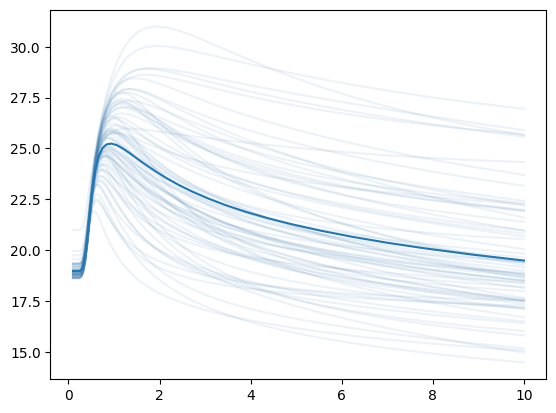

In [266]:
plt.plot(sigma_range, psnr_estimates.T, c='steelblue', alpha=0.1)
plt.plot(sigma_range, mean_psnr)
# plt.fill_between(sigma_range, mean_psnr + 2 * std_psnr, mean_psnr - 2 * std_psnr, alpha=0.1)